In [11]:
# 核心库
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from chromasky_toolkit import config

print("✅ 环境设置完毕。")

✅ 环境设置完毕。


In [12]:
def analyze_nc_file(file_path: Path):
    """
    分析指定的 NetCDF 文件，并打印出可供分离的参数。
    """
    if not file_path.exists():
        print(f"❌ 文件不存在: {file_path}")
        return

    print(f"--- 正在分析文件: {file_path.name} ---")
    with xr.open_dataset(file_path, engine="netcdf4") as ds:
        # 1. 提取可用的 UTC 日期
        # 假设时间坐标名为 'valid_time' 或 'time'
        time_coord_name = 'valid_time' if 'valid_time' in ds.coords else 'time'
        if time_coord_name in ds.coords:
            unique_dates = pd.to_datetime(ds[time_coord_name].values).strftime('%Y-%m-%d').unique().tolist()
            print("\n【可用的 UTC 日期】:")
            for d in unique_dates:
                print(f"- {d}")

            # 2. 提取可用的 UTC 时间
            unique_times = pd.to_datetime(ds[time_coord_name].values).strftime('%H:%M').unique().tolist()
            print("\n【可用的 UTC 时间 (小时:分钟)】:")
            # 每行打印 6 个，方便查看
            for i in range(0, len(unique_times), 6):
                print("- " + "  ".join(unique_times[i:i+6]))
        else:
            print("未找到有效的时间坐标 ('valid_time' 或 'time')。")

        # 3. 提取可用的图层 (数据变量)
        print("\n【可用的图层 (变量)】:")
        for var_name in ds.data_vars:
            print(f"- {var_name:<10} ({ds[var_name].attrs.get('long_name', 'N/A')})")

# --- 执行分析 ---
TARGET_DATE_STR = "2025-07-04"
target_date_obj = pd.to_datetime(TARGET_DATE_STR).date()
raw_data_path = config.ERA5_DATA_DIR / target_date_obj.strftime('%Y-%m-%d') / "era5_data.nc"

analyze_nc_file(raw_data_path)

--- 正在分析文件: era5_data.nc ---

【可用的 UTC 日期】:
- 2025-07-03
- 2025-07-04

【可用的 UTC 时间 (小时:分钟)】:
- 00:00  10:00  11:00  12:00  13:00  20:00
- 21:00  22:00  23:00

【可用的图层 (变量)】:
- hcc        (High cloud cover)
- mcc        (Medium cloud cover)
- lcc        (Low cloud cover)
- tcc        (Total cloud cover)
- sp         (Surface pressure)
- t2m        (2 metre temperature)
- d2m        (2 metre dewpoint temperature)


#【步骤一】替换 extract_and_save_slice 函数定义
这个新版本接受一个变量列表作为参数。

In [13]:
# 我们回到最初的单变量提取版本，因为它更适合当前的需求
def extract_and_save_slice(source_nc_path: Path, utc_date: str, utc_time: str, variable: str) -> Path | None:
    """
    从大的 NetCDF 文件中提取一个【单变量】的数据切片并保存。
    """
    if not source_nc_path.exists():
        print(f"❌ 源文件不存在: {source_nc_path}")
        return None

    with xr.open_dataset(source_nc_path, engine="netcdf4") as ds:
        try:
            target_datetime = f"{utc_date}T{utc_time}"
            time_coord_name = 'valid_time' if 'valid_time' in ds.coords else 'time'
            
            # 选择单个变量进行切片
            data_slice = ds[variable].sel({time_coord_name: target_datetime}, method='nearest')
            
            # 构建输出路径，文件名包含变量名
            time_str_for_path = utc_time.replace(':', '')
            output_dir = config.PROCESSED_DATA_DIR / utc_date
            output_dir.mkdir(parents=True, exist_ok=True)
            output_path = output_dir / f"{variable}_{time_str_for_path}.nc"
            
            data_slice.to_netcdf(output_path)
            print(f"✅ 单变量数据切片 [{variable}] 已成功保存到: {output_path}")
            return output_path
            
        except KeyError:
            print(f"❌ 错误: 变量 '{variable}' 或时间坐标 '{time_coord_name}' 在数据集中不存在。")
        except Exception as e:
            print(f"❌ 提取或保存时发生错误: {e}")
        
    return None

#【步骤三】替换“执行与可视化”的主流程
这个最终的单元格现在将串联起提取 -> 计算 -> 可视化这三个步骤。

2025-08-06 19:11:25,695 - MapDrawer - INFO - --- [绘图] 开始生成地图: High cloud cover on 2023-10-01 at 12:00 UTC ---



开始批量处理和可视化以下变量: ['hcc', 'mcc', 'lcc']

--- 正在处理变量: hcc ---
✅ 单变量数据切片 [hcc] 已成功保存到: C:\Users\zhang\Documents\Code\chromasky-toolkit\data\processed\2023-10-01\hcc_1200.nc


2025-08-06 19:11:28,181 - MapDrawer - INFO - --- [绘图] 地图已成功保存到: C:\Users\zhang\Documents\Code\chromasky-toolkit\data\processed\2023-10-01\hcc_1200.png ---


✅ 变量 [hcc] 的地图生成成功！正在 Notebook 中显示...


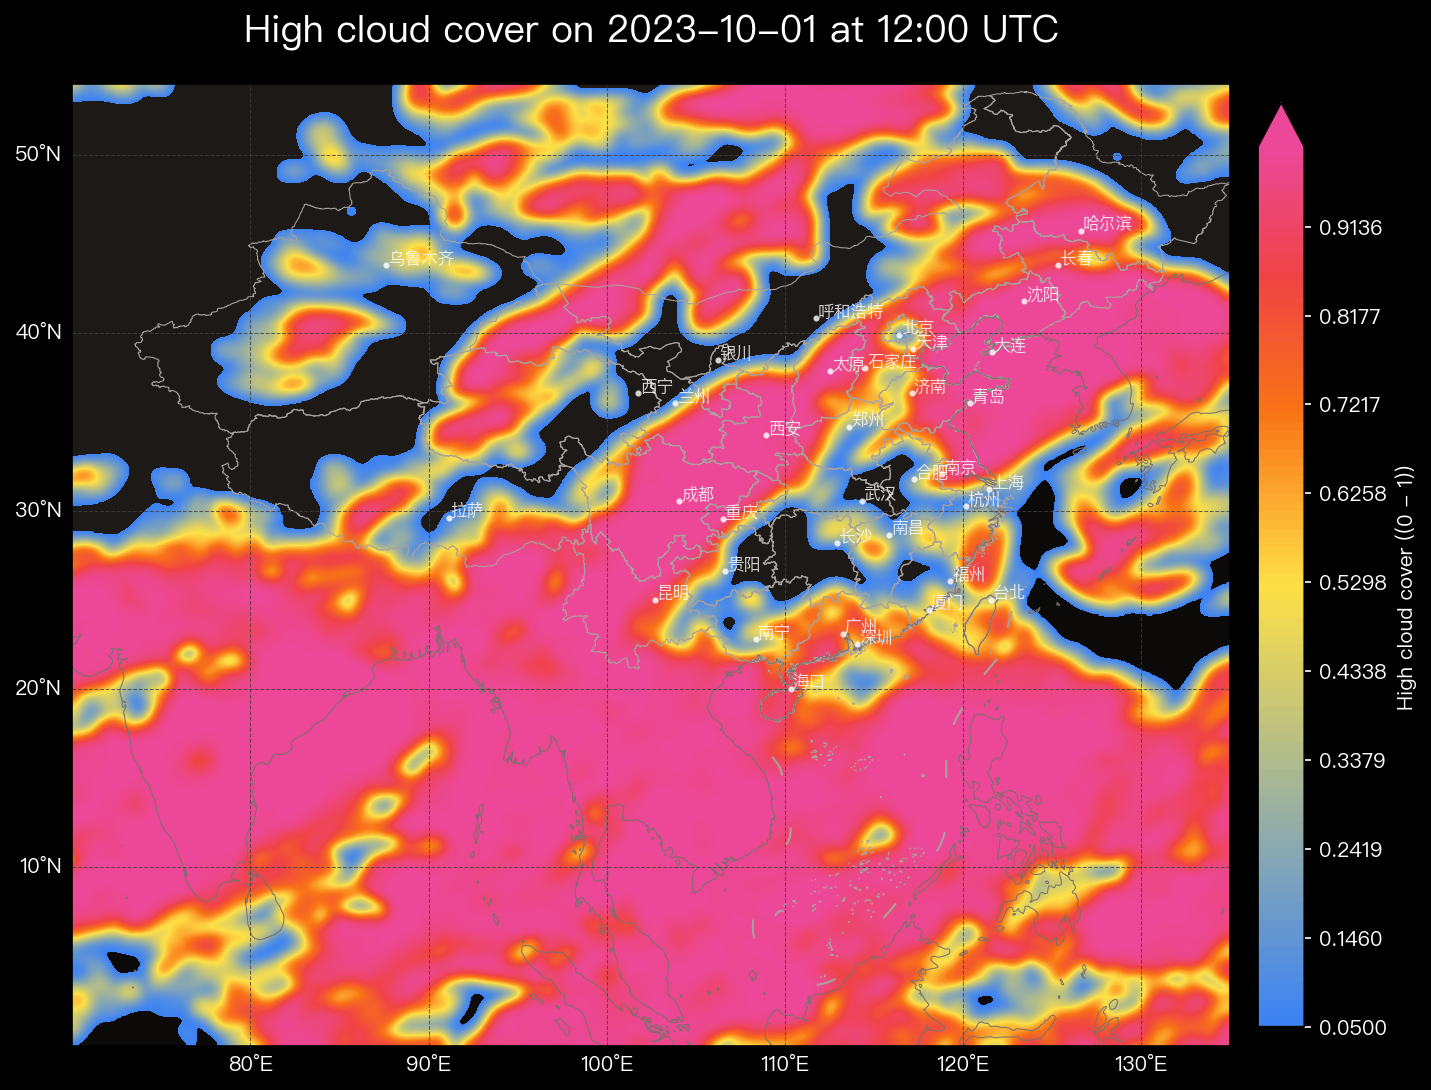

2025-08-06 19:11:28,239 - MapDrawer - INFO - --- [绘图] 开始生成地图: Medium cloud cover on 2023-10-01 at 12:00 UTC ---



--------------------------------------------------------------------------------

--- 正在处理变量: mcc ---
✅ 单变量数据切片 [mcc] 已成功保存到: C:\Users\zhang\Documents\Code\chromasky-toolkit\data\processed\2023-10-01\mcc_1200.nc


2025-08-06 19:11:30,713 - MapDrawer - INFO - --- [绘图] 地图已成功保存到: C:\Users\zhang\Documents\Code\chromasky-toolkit\data\processed\2023-10-01\mcc_1200.png ---


✅ 变量 [mcc] 的地图生成成功！正在 Notebook 中显示...


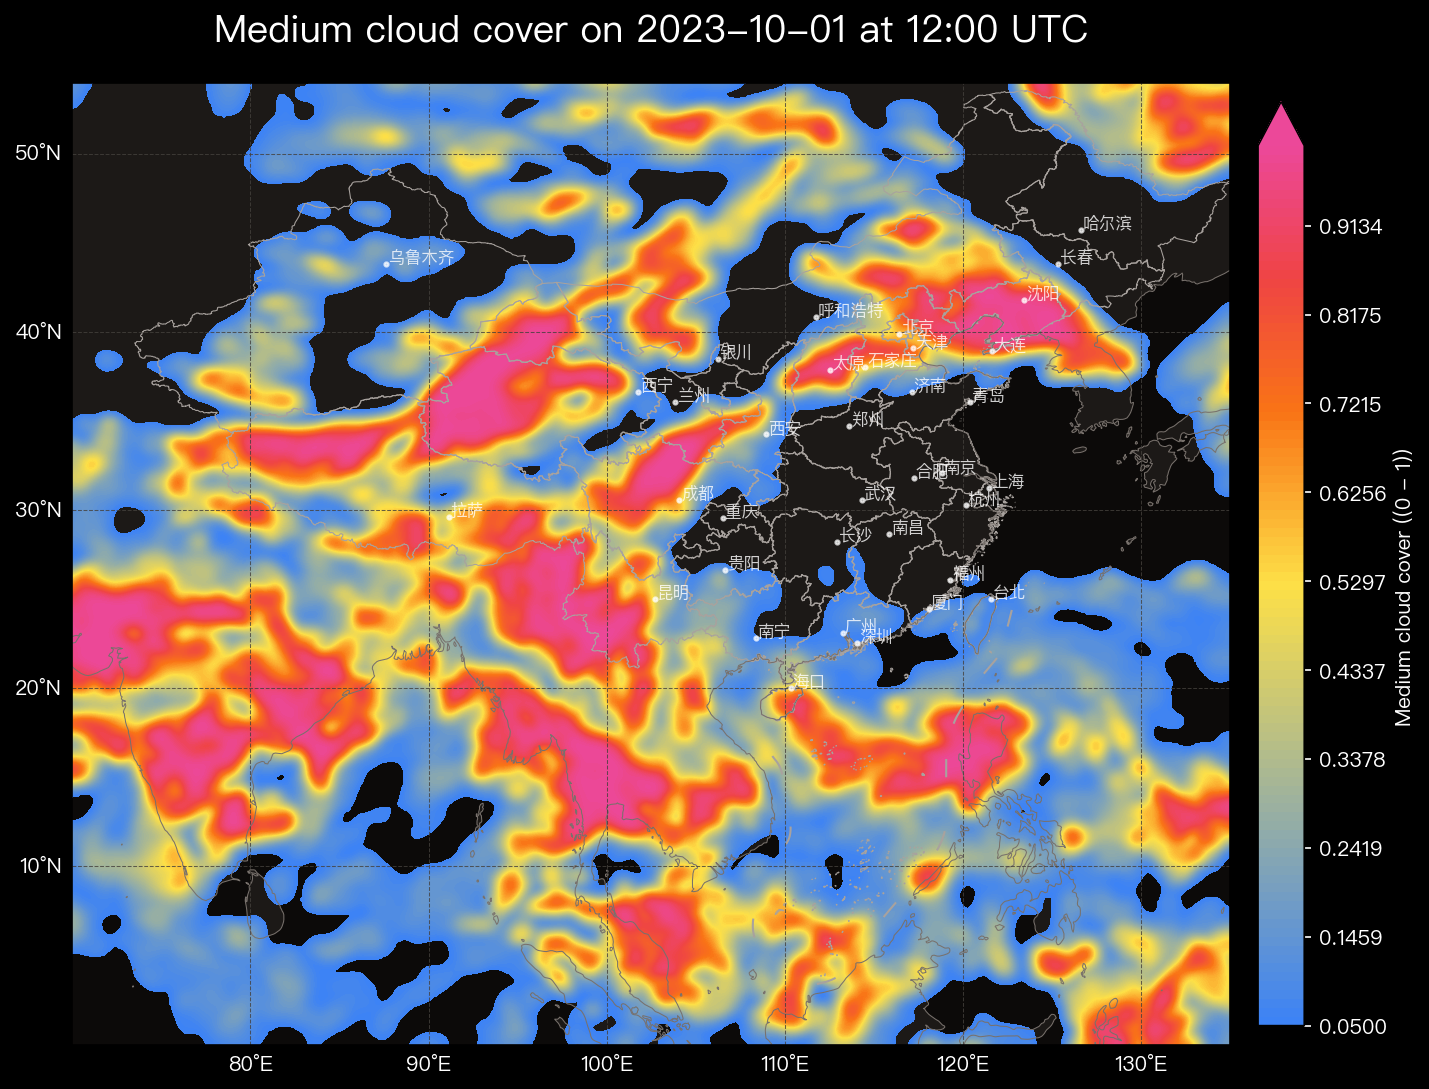

2025-08-06 19:11:30,771 - MapDrawer - INFO - --- [绘图] 开始生成地图: Low cloud cover on 2023-10-01 at 12:00 UTC ---



--------------------------------------------------------------------------------

--- 正在处理变量: lcc ---
✅ 单变量数据切片 [lcc] 已成功保存到: C:\Users\zhang\Documents\Code\chromasky-toolkit\data\processed\2023-10-01\lcc_1200.nc


2025-08-06 19:11:33,179 - MapDrawer - INFO - --- [绘图] 地图已成功保存到: C:\Users\zhang\Documents\Code\chromasky-toolkit\data\processed\2023-10-01\lcc_1200.png ---


✅ 变量 [lcc] 的地图生成成功！正在 Notebook 中显示...


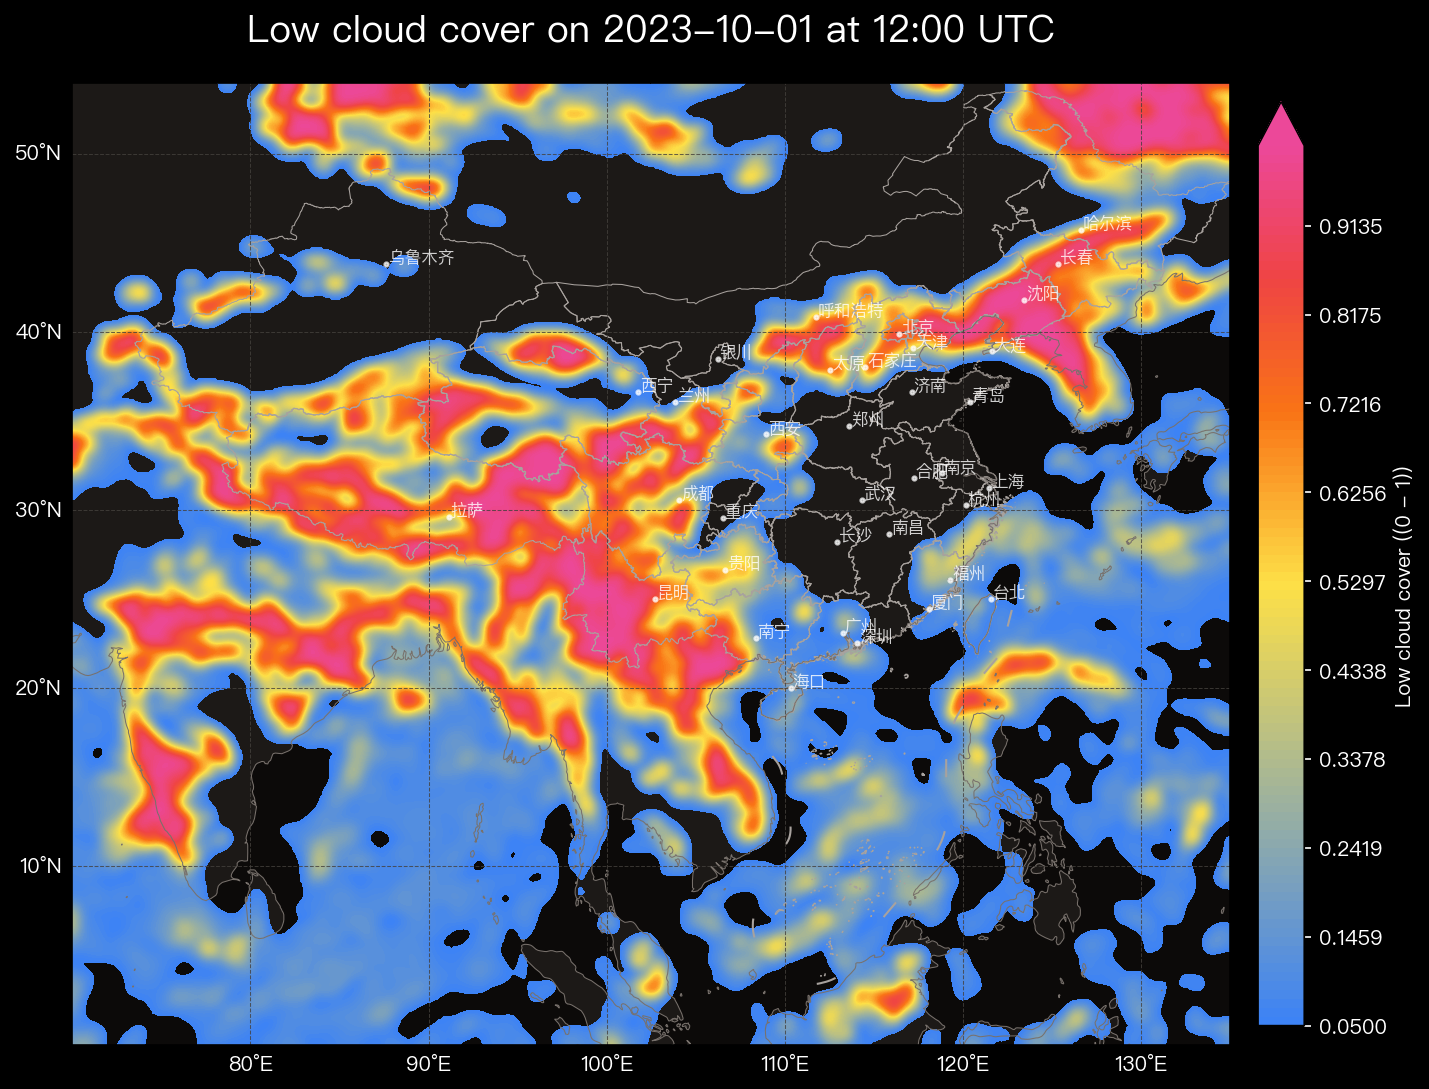


--------------------------------------------------------------------------------



In [14]:
# --- 导入我们重构好的绘图函数 ---
from chromasky_toolkit.map_drawer import generate_map_from_grid
from IPython.display import display, Image # 确保 Image 已导入
# --- 步骤 1: 定义参数 ---

# 定义我们要分析的原始数据文件
# (假设 raw_data_path 已经在之前的单元格中定义好了)
if 'raw_data_path' not in locals() or not raw_data_path.exists():
    print("❌ 原始数据文件 'raw_data_path' 未定义或不存在，无法继续。")
else:
    # 定义我们感兴趣的时间点
    target_utc_date = "2023-10-01"
    target_utc_time = "12:00"  # UTC 12:00 (北京时间 20:00)

    # **关键修改：定义一个要循环处理的变量列表**
    variables_to_process = ["hcc", "mcc", "lcc"] 

    # --- 步骤 2 & 3: 循环处理、保存和绘图 ---
    
    print("\n" + "="*80)
    print(f"开始批量处理和可视化以下变量: {variables_to_process}")
    print("="*80 + "\n")

    for variable in variables_to_process:
        print(f"--- 正在处理变量: {variable} ---")
        
        # 1. 分别提取和保存每个变量的数据切片
        saved_slice_path = extract_and_save_slice(raw_data_path, target_utc_date, target_utc_time, variable)
        
        # 2. 如果保存成功，则为其绘制地图
        if saved_slice_path and saved_slice_path.exists():
            # 加载刚刚分离出来的数据
            data_slice = xr.open_dataarray(saved_slice_path)
            
            # 创建一个描述性的标题
            map_title = f"{data_slice.attrs.get('long_name', data_slice.name)} on {target_utc_date} at {target_utc_time} UTC"
            
            # 定义地图图片的输出路径
            map_output_path = saved_slice_path.with_suffix('.png')
            
            # 调用绘图函数
            image_bytes = generate_map_from_grid(data_slice, map_title, map_output_path)
            
            # 在 Notebook 中显示生成的地图
            if image_bytes:
                print(f"✅ 变量 [{variable}] 的地图生成成功！正在 Notebook 中显示...")
                display(Image(data=image_bytes, width=600))
            else:
                print(f"❌ 变量 [{variable}] 的地图生成失败。")
        else:
            print(f"⚠️ 变量 [{variable}] 的数据切片未能成功保存，跳过绘图。")
        
        print("\n" + "-"*80 + "\n") # 添加分隔线，让输出更清晰